In [1]:
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
from model import Generator
from util import *

plt.rcParams['figure.dpi'] = 150

device = 'cuda' #@param ['cuda', 'cpu']

generator1 = Generator(256, 512, 8, channel_multiplier=2).eval().to(device)
generator2 = Generator(256, 512, 8, channel_multiplier=2).to(device).eval()

mean_latent1 = load_model(generator1, 'face.pt')
mean_latent2 = load_model(generator2, 'disney.pt')

print(len(mean_latent1))
print(mean_latent1[0].shape)
num_swap =  6
alpha =  0.5

early_alpha = 0

truncation = .5


20
torch.Size([1, 512])


In [2]:
def toonify(latent1, latent2):
    with torch.no_grad():
        noise1 = [getattr(generator1.noises, f'noise_{i}') for i in range(generator1.num_layers)]
        noise2 = [getattr(generator2.noises, f'noise_{i}') for i in range(generator2.num_layers)]

        out1 = generator1.input(latent1[0])
        out2 = generator2.input(latent2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        out1, _ = generator1.conv1(out, latent1[0], noise=noise1[0])
        out2, _ = generator2.conv1(out, latent2[0], noise=noise2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        skip1 = generator1.to_rgb1(out, latent1[1])
        skip2 = generator2.to_rgb1(out, latent2[1])
        skip = (1-early_alpha)*skip1 + early_alpha*skip2

        i = 2
        for conv1_1, conv1_2, noise1_1, noise1_2, to_rgb1, conv2_1, conv2_2, noise2_1, noise2_2, to_rgb2 in zip(
            generator1.convs[::2], generator1.convs[1::2], noise1[1::2], noise1[2::2], generator1.to_rgbs,
            generator2.convs[::2], generator2.convs[1::2], noise2[1::2], noise2[2::2], generator2.to_rgbs
        ):


            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_1(out, latent1[i], noise=noise1_1)
            out2, _ = conv2_1(out, latent2[i], noise=noise2_1)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_2(out, latent1[i], noise=noise1_2)
            out2, _ = conv2_2(out, latent2[i], noise=noise2_2)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            skip1 = to_rgb1(out, latent1[i], skip)
            skip2 = to_rgb2(out, latent2[i], skip)
            skip = (1-conv_alpha)*skip1 + conv_alpha*skip2

            i += 1

    image = skip.clamp(-1,1)
    
    return image

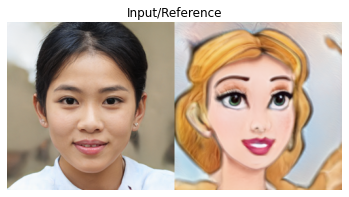

In [25]:
face_seed   = 314115 #@param {type:"number"} 
disney_seed = 7492557 #@param {type:"number"} 
    
with torch.no_grad():
    torch.manual_seed(face_seed)
    source_code = torch.randn([1, 512]).to(device)
    latent1 = generator1.get_latent(source_code, truncation=truncation, mean_latent=mean_latent1)
    source_im, _ = generator1(latent1)

    torch.manual_seed(disney_seed)
    reference_code = torch.randn([1, 512]).to(device)
    latent2 = generator2.get_latent(reference_code, truncation=truncation, mean_latent=mean_latent2)
    reference_im, _ = generator2(latent2)

    display_image(torch.cat([source_im, reference_im], -1), size=None, title='Input/Reference')

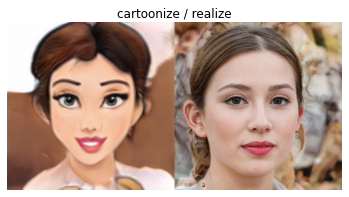

In [26]:
source_im1, _ = generator2(latent1)
source_im2, _ = generator1(latent2)

display_image(torch.cat([source_im1, source_im2], -1),size=None, title='cartoonize / realize')

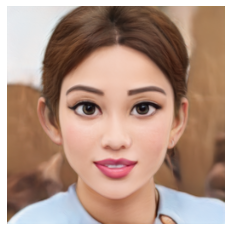

In [27]:
result = toonify(latent1, latent2)

display_image(result)

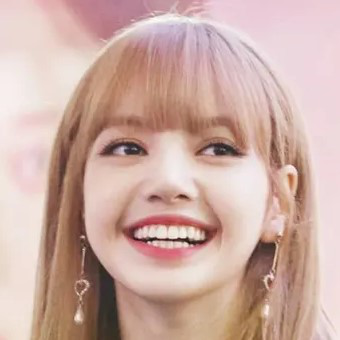

In [7]:
from PIL import Image

name = 'lisa'

Image.open('test_pics/'+name+'.jpg')

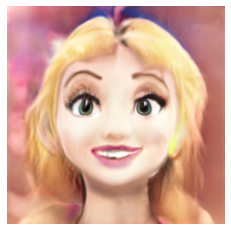

In [8]:
latent_real = load_source([name], generator1, device)

source_im, _ = generator2(latent_real)

display_image(source_im)

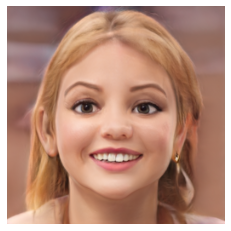

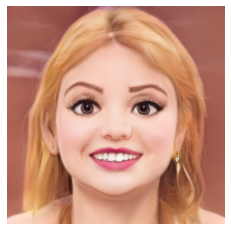

In [9]:
result1 = toonify(latent_real, latent1)
result2 = toonify(latent_real, latent2)

display_image(result1)
display_image(result2)

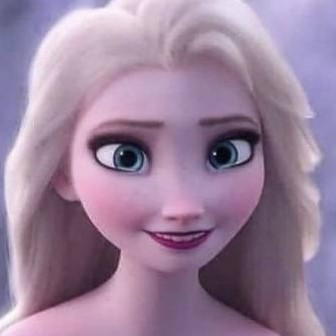

In [29]:
from PIL import Image

name = 'elsa'

Image.open('test_pics/'+name+'.jpg')

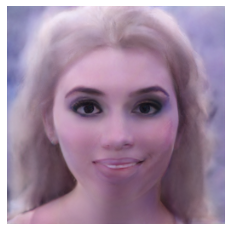

In [30]:
latent_cartoon = load_source([name], generator1, device)

source_im1, _ = generator1(latent_cartoon)

display_image(source_im1)

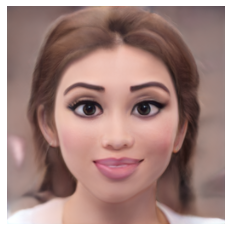

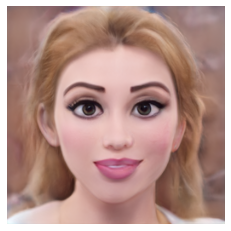

In [31]:
result1 = toonify(latent_cartoon, latent1)
result2 = toonify(latent_cartoon, latent2)

display_image(result1)
display_image(result2)